<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) | [Contents](Index.ipynb) |

# Boutique photometry collection for V819 Tau

Note, this boutique analysis for one target is now deprecated and superceded by our new "master" photometry.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [3]:
import pandas as pd

In [6]:
import sys
import os

In [7]:
sys.path.append(os.path.abspath("../code/"))

In [8]:
from xphotometryx import flat_grankin08
from xphotometryx import flat_ASASSN
from xphotometryx import jd_to_date
from xphotometryx import assign_season
from xphotometryx import plot_season_postage_stamps

## Grankin et al. 2008  Data

Assign uncertainty in $V$ for the Grankin data.
From Grankin et al. 2008: 
> The rms error of a single measurement in the instrumental system for a star brighter than 12 mag in $V$ is about 0.01 in $BVR$ and 0.05 in $U$.

In [9]:
gr_data = flat_grankin08('../data/Grankin_2008/v819tau.dat')

In [10]:
gr_data.head(2)

,JD_like,Vmag,Bmag,Rmag,Umag,Berr,Verr,Rerr,Uerr,date_type,source,n_obs
0,2.448126e+06,13.095,14.701,11.667,NaN,0.01,0.01,0.01,0.05,HJD,Grankin et al. 2008,1.0
1,2.448127e+06,13.152,14.728,11.683,NaN,0.01,0.01,0.01,0.05,HJD,Grankin et al. 2008,1.0


## Use Aggregated ASASSN Data

In [11]:
ASASSN_data = flat_ASASSN('../data/ASASSN/V819Tau_ASASSN_20170803.csv')
ASASSN_data.head(2)

,JD_like,Vmag,Verr,n_obs,date_type,source
0,2.456594e+06,13.1625,0.03182,2.0,HJD,ASASSN
1,2.456600e+06,13.1040,0.01000,1.0,HJD,ASASSN


## ASAS3

In [12]:
# todo

## AAVSO

In [13]:
# todo

## Concatenate all photometry into a "database"

In [14]:
master = pd.concat([gr_data, ASASSN_data], join='outer', ignore_index=True, axis=0)

## Convert Julian Dates to year, month, day

From JiffyClub's [gist](https://gist.github.com/jiffyclub/1294443):

In [15]:
master['year'], master['month'], master['day'] = jd_to_date(master.JD_like.values)

# Break the observations into **seasons**
Seasons are divided by their observability (can't observe towards the sun!):

May is the dividing line (makes sense, the sun is in Taurus in May... e.g. my birthday is May 6th and I am a Taurus).

In [16]:
master = assign_season(master)

Re-organize the columns

In [17]:
col_order = ['JD_like', 'year', 'month', 'day', 'season', 
                'Vmag', 'Verr', 'Bmag', 'Berr', 'Rmag', 'Rerr', 'Umag', 'Uerr',
                 'source', 'date_type']
master = master[col_order]

Make sure uncertainties are NaN if mag is NaN.

In [18]:
master.Verr[master.Vmag != master.Vmag] = np.NaN
master.Rerr[master.Rmag != master.Rmag] = np.NaN
master.Berr[master.Bmag != master.Bmag] = np.NaN
master.Uerr[master.Umag != master.Umag] = np.NaN

## Metadata for observing "seasons"

Estimate the period separately for each season:

In [19]:
seasons_unsorted = master.season.unique()
seasons_unsorted.sort()
seasons = seasons_unsorted

In [20]:
seasons

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 29, 30,
       31, 32, 33])

In [21]:
n_seasons = len(seasons)

In [22]:
average_period = 5.533

In [23]:
max_peaks = np.array([average_period]*n_seasons)
P_errs = np.array([0.1]*n_seasons)

In [24]:
season_agg = pd.DataFrame({"season":seasons,
                           "P_est1":max_peaks,
                           "P_err1":P_errs})

Add some metadata:

In [25]:
season_agg['years'] = ''
season_agg['N_obs'] = 0
season_agg['JD_min'] = 0.0
season_agg['JD_max'] = 0.0
season_agg['N_U'] = 0
season_agg['N_B'] = 0
season_agg['N_V'] = 0
season_agg['N_R'] = 0

In [26]:
for i in range(n_seasons):
    # get the data and best-fit angular frequency
    s = season_agg.season[i]
    ids = master.season == s
    df = master[ids]
    season_agg.years[i] = "{}/{}-{}/{}".format(df.month[df.JD_like.argmin()],
                                               df.year.min(), 
                                               df.month[df.JD_like.argmax()],
                                               df.year.max())
    season_agg.N_obs[i] = len(df.Vmag)
    season_agg.JD_min[i] = df.JD_like.min()
    season_agg.JD_max[i] = df.JD_like.max()
    season_agg.N_U[i] = (df.Umag == df.Umag).sum()
    season_agg.N_B[i] = (df.Bmag == df.Bmag).sum()
    season_agg.N_V[i] = (df.Vmag == df.Vmag).sum()
    season_agg.N_R[i] = (df.Rmag == df.Rmag).sum()

In [27]:
season_agg['length'] = np.ceil(season_agg.JD_max-season_agg.JD_min)

In [28]:
season_agg

,P_err1,P_est1,season,years,N_obs,JD_min,JD_max,N_U,N_B,N_V,N_R,length
0,0.1,5.533,6,8/1990-1/1991,57,2.448126e+06,2.448271e+06,8,57,57,49,145.0
1,0.1,5.533,7,8/1991-11/1991,37,2.448485e+06,2.448572e+06,3,37,37,20,87.0
2,0.1,5.533,8,8/1992-11/1992,42,2.448844e+06,2.448956e+06,0,42,42,9,112.0
3,0.1,5.533,9,8/1993-10/1993,25,2.449226e+06,2.449277e+06,2,25,25,19,51.0
4,0.1,5.533,10,8/1994-10/1994,25,2.449575e+06,2.449640e+06,2,25,25,24,65.0
5,0.1,5.533,11,8/1995-10/1995,26,2.449941e+06,2.450022e+06,3,26,26,24,81.0
6,0.1,5.533,12,10/1996-11/1996,16,2.450365e+06,2.450417e+06,0,16,16,16,53.0
7,0.1,5.533,13,9/1997-11/1997,21,2.450716e+06,2.450760e+06,0,21,21,21,45.0
8,0.1,5.533,14,11/1998-12/1998,7,2.451139e+06,2.451165e+06,0,7,7,7,27.0
9,0.1,5.533,15,8/1999-12/1999,36,2.451408e+06,2.451529e+06,4,36,36,36,121.0


## Metadata for observing "epochs"

In [26]:
epochs_all = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=['OBJECT', 'ACQTIME'])
epochs_all

,ACQTIME,OBJECT
0,2.456981e+06,Anon1
1,2.456982e+06,HD283572
2,2.456983e+06,V827Tau
3,2.456983e+06,Hubble_4
4,2.456985e+06,IW Tau A
5,2.456988e+06,LkCa 19
6,2.456990e+06,LkCa 1
7,2.456991e+06,V826 Tau
8,2.456991e+06,HBC 388
9,2.456991e+06,LkCa 4 A


In [27]:
epochs = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=['OBJECT', 'ACQTIME'])

In [28]:
epochs = epochs.rename(columns={'ACQTIME':'JD_like'})

In [29]:
epochs = epochs[epochs.OBJECT=='V819Tau']

In [30]:
epochs['Observation'] = 'IGRINS'
epochs['Instrument'] = 'IGRINS'

In [31]:
epochs = epochs.reset_index(drop=True)

Associate each epoch with the closest season

In [32]:
epochs['InSeason'] = np.NaN
epochs['NearSeason'] = np.NaN
epochs['dist_hi'] = np.NaN
epochs['dist_lo'] = np.NaN
epochs['season_hi'] = np.NaN
epochs['season_lo'] = np.NaN

In [33]:
epochs.JD_like

0    2.456991e+06
Name: JD_like, dtype: float64

In [34]:
for i in range(len(epochs)):
    sid = (season_agg.JD_min < epochs.JD_like[i]) & (season_agg.JD_max > epochs.JD_like[i])
    if sid.sum()==1:
        epochs.InSeason[i] = season_agg.season[sid]
    else:
        dist_lo = np.abs(epochs.JD_like[i]-season_agg.JD_min)
        dist_hi = np.abs(epochs.JD_like[i]-season_agg.JD_max) 
        s_hi = np.argmin(dist_hi)
        s_lo = s_hi+1
        epochs.season_hi[i] = season_agg.season[s_hi]
        epochs.season_lo[i] = season_agg.season[s_lo]
        epochs.dist_hi[i] = np.ceil(dist_hi[s_hi])
        epochs.dist_lo[i] = np.ceil(dist_lo[s_lo])

All of the epochs that were missed come just-after the end of the season by between 22 to 126 days.

In [35]:
epochs.NearSeason = epochs.season_hi

In [36]:
epochs['AdoptedSeason'] = epochs.InSeason
out_of_season = epochs.InSeason != epochs.InSeason
epochs.AdoptedSeason[out_of_season] = epochs.NearSeason[out_of_season]

Placeholders for BVR magnitude estimates:

In [37]:
epochs['B_est'], epochs['V_est'], epochs['R_est'] = 0.0, 0.0, 0.0

In [38]:
epochs['JD-2450000'] = epochs.JD_like-2450000.0

We don't want to label everything we know about:

In [39]:
epochs.drop(epochs.index[epochs.Observation.isin(
            ['Nguyen_1', 'Nguyen_2', 'Nguyen_3', 'Nguyen_4','IGRINS_1'])], inplace=True)

In [40]:
epochs = epochs.reset_index(drop=True)

In [41]:
epoch_ls = pd.DataFrame(columns=['Instrument', 'color', 'linestyles'])

epoch_ls = epoch_ls.append({"Instrument":'ESPaDOnS', "color":'gray', 'linestyles':'dotted'}, ignore_index=True)
epoch_ls = epoch_ls.append({"Instrument":'IGRINS', "color":'black', 'linestyles':'solid'}, ignore_index=True)
epoch_ls = epoch_ls.append({"Instrument":'2MASS', "color":'red', 'linestyles':'dashed'}, ignore_index=True)
epoch_ls = epoch_ls.append({"Instrument":'DoubleSpec', "color":'blue', 'linestyles':'dotted'}, ignore_index=True)
epoch_ls = epoch_ls.append({"Instrument":'TripleSpec', "color":'blue', 'linestyles':'dashed'}, ignore_index=True)

In [42]:
epochs_orig = epochs.copy()

In [43]:
epochs = pd.merge(epochs, epoch_ls, on='Instrument')

## Lightcurve analysis

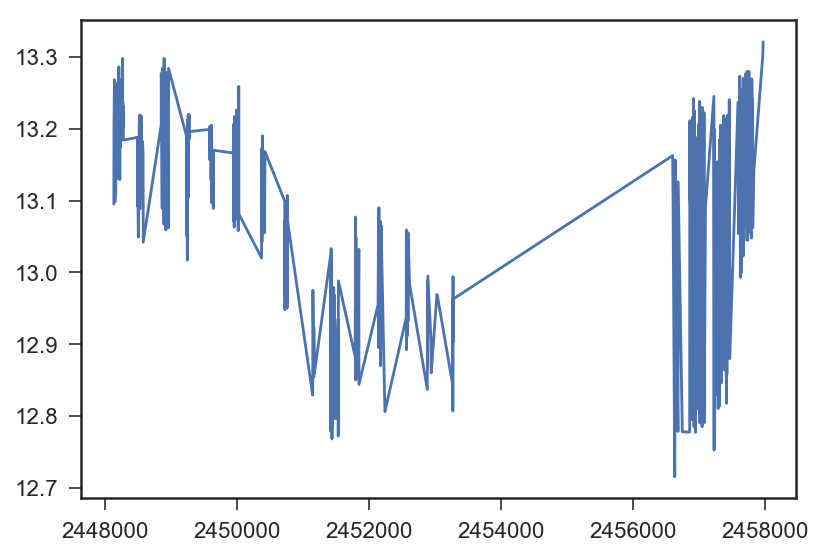

In [44]:
plt.plot(master.JD_like, master.Vmag)

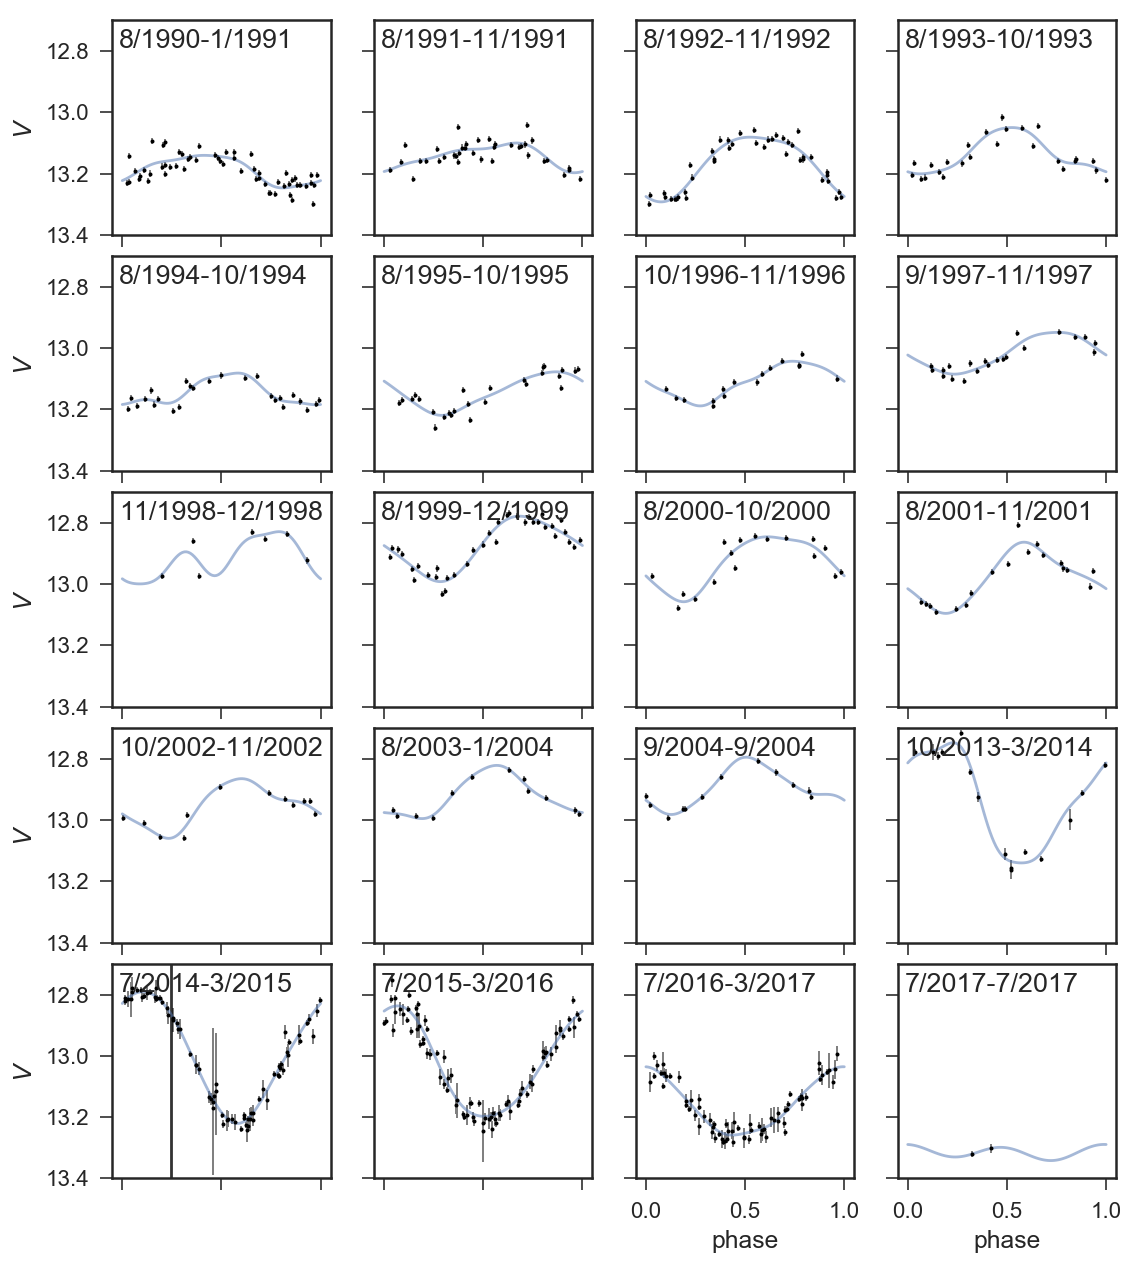

In [45]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(13.4, 12.7), savefig_file='../results/test_V.pdf', ylabel='$V$')

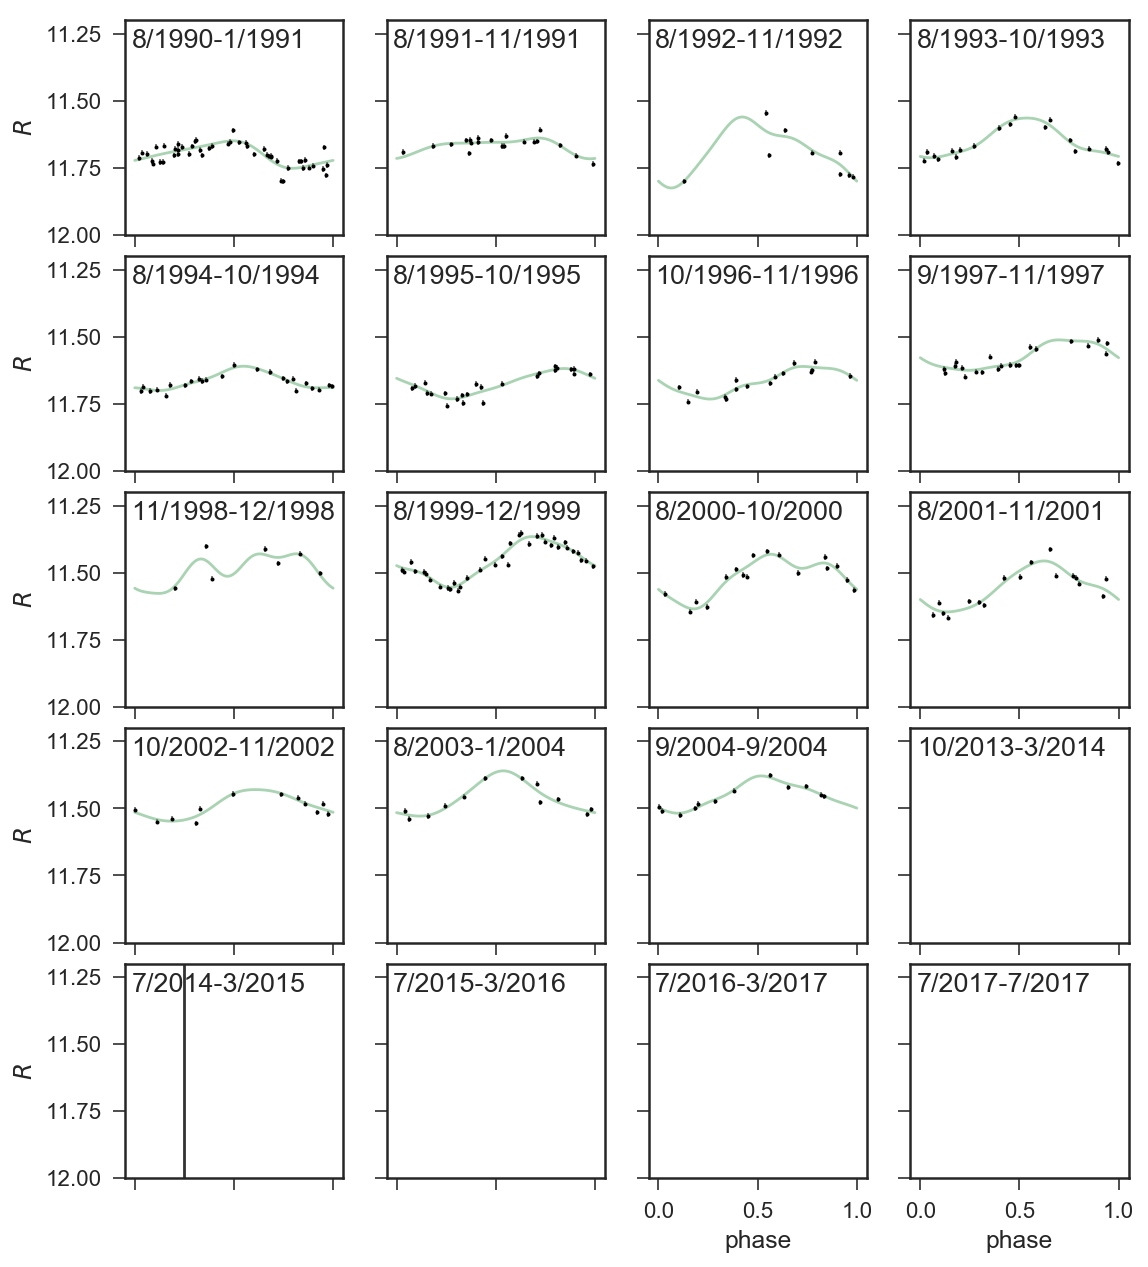

In [52]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(12.00, 11.20), savefig_file='../results/test_R.pdf', ylabel='$R$')

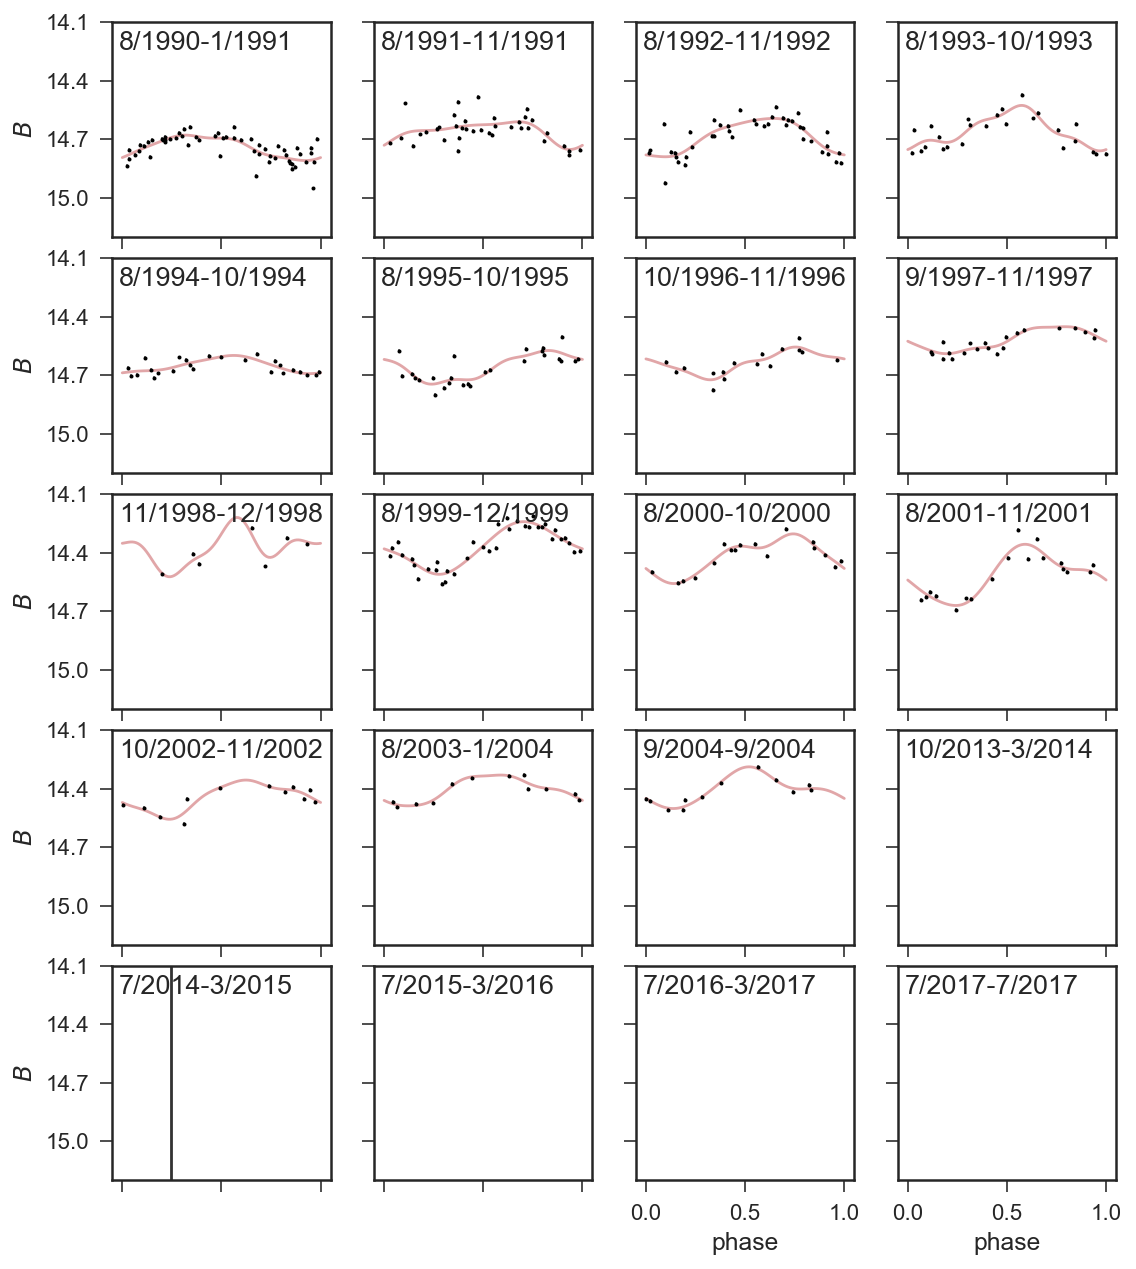

In [57]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(15.2, 14.1), savefig_file='../results/test_B.pdf', ylabel='$B$')

## Summarize estimated photometry into a table

Drop the Observations that we are not using: Nguyen, IGRINS_1.  
Drop the columns we are not using (most columns).  
Add a column for JD-2456000 to match Donati et al. 2014.

In [58]:
eps = epochs.copy()

keep = ['JD-2450000','Instrument', 'B_est', 'V_est', 'R_est']
discard = set(eps.columns.values) - set(keep)
eps.drop(list(discard), axis=1, inplace=True)
eps.replace(0.0, np.NaN, inplace=True)
eps[keep]

,JD-2450000,Instrument,B_est,V_est,R_est
0,6990.883958,IGRINS,NaN,12.866358,NaN


## Full range of data

Photometric sources:

In [59]:
master.source.unique()

array(['Grankin et al. 2008', 'ASASSN'], dtype=object)

In [62]:
#sources = ['Vrba et al. 1993', 'Bouvier et al. 1993','Grankin et al. 2008', 'ASAS3',
#           'Integral-OMC','Donati et al. 2014','ASASSN','AAVSO', 'Grankin unpublished']
sources = ['Grankin et al. 2008', 'ASASSN']

In [63]:
fmts = ['s', '.']

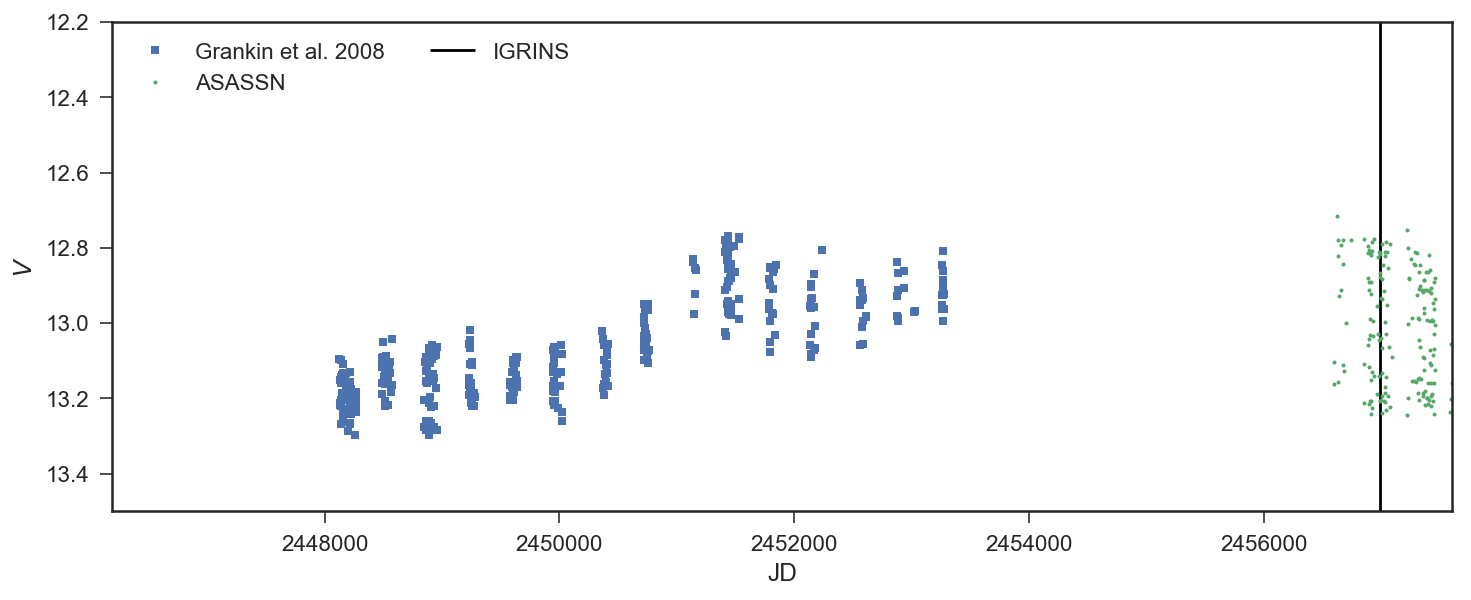

In [65]:
plt.figure(figsize=(12, 4.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    plt.plot(master.JD_like[inds], master.Vmag[inds], fmt, ms=4,label=source)

for i in range(len(epochs)):
    label = epochs.Instrument[i]
    plt.vlines(epochs.JD_like[i], 13.5, 12.2, colors=epochs.color[i], 
               linestyles=epochs.linestyles[i], label = label)
    
#plt.vlines(2446192.083333, 13.5, 12.2, colors='cyan', linestyles='dashed')

legend = plt.legend(loc='upper left', ncol=2)#, frameon=True, shadow=False, )
plt.ylim(13.5, 12.2)

plt.ylabel('$V$')
plt.xlabel('JD')

plt.xlim(2446192.083333, 2457597.833333)
plt.savefig('../results/V819_phot1986-2017.pdf', bbox_inches='tight')

## Table of estimated $V$ values at the time of observations

In [66]:
eps = eps[keep]

In [67]:
eps

,JD-2450000,Instrument,B_est,V_est,R_est
0,6990.883958,IGRINS,NaN,12.866358,NaN


In [68]:
latex_fmts = [lambda x:"{:0.4f}".format(x), lambda x:"{}".format(x), 
        lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x)]

In [69]:
tbl_out = eps

In [70]:
print(tbl_out.to_latex(index=False, na_rep='$\cdots$', formatters=latex_fmts))

\begin{tabular}{rlrrr}
\toprule
JD-2450000 & Instrument & B\_est & V\_est & R\_est \\
\midrule
 6990.8840 &     IGRINS &   nan & 12.87 &   nan \\
\bottomrule
\end{tabular}



## Make sure we save the master data file!

In [71]:
master

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr,source,date_type
0,2.448126e+06,1990,8,22.971300,6,13.095000,0.010000,14.701,0.01,11.667,0.01,NaN,NaN,Grankin et al. 2008,HJD
1,2.448127e+06,1990,8,23.970200,6,13.152000,0.010000,14.728,0.01,11.683,0.01,NaN,NaN,Grankin et al. 2008,HJD
2,2.448129e+06,1990,8,25.956100,6,13.213000,0.010000,14.775,0.01,11.708,0.01,NaN,NaN,Grankin et al. 2008,HJD
3,2.448130e+06,1990,8,26.958000,6,13.216000,0.010000,14.842,0.01,NaN,NaN,NaN,NaN,Grankin et al. 2008,HJD
4,2.448135e+06,1990,8,31.954100,6,13.268000,0.010000,14.797,0.01,11.751,0.01,NaN,NaN,Grankin et al. 2008,HJD
5,2.448136e+06,1990,9,1.952600,6,13.204000,0.010000,14.772,0.01,11.674,0.01,NaN,NaN,Grankin et al. 2008,HJD
6,2.448139e+06,1990,9,4.951700,6,13.160000,0.010000,14.786,0.01,11.610,0.01,NaN,NaN,Grankin et al. 2008,HJD
7,2.448140e+06,1990,9,5.944700,6,13.218000,0.010000,14.889,0.01,11.707,0.01,NaN,NaN,Grankin et al. 2008,HJD
8,2.448141e+06,1990,9,6.948300,6,13.220000,0.010000,14.852,0.01,11.721,0.01,16.847,0.05,Grankin et al. 2008,HJD
9,2.448142e+06,1990,9,7.945800,6,13.143000,0.010000,14.756,0.01,11.694,0.01,NaN,NaN,Grankin et al. 2008,HJD


In [98]:
#master.to_csv('../data/photometry/master_LkCa4_photometry.csv', index=False)

## The end.

<!--NAVIGATION-->
< [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) | [Contents](Index.ipynb) |